# Árboles de decisión 2

### Daniel Marín López

---

Hay que crear dos modelos de árboles de decisión (random forest, gradient boosting) para los siguientes datasets:

* Predicción de alquileres de casas en California.
* Potabilidad del agua según los datos de este dataset.

Además hay que indicar la importancia de cada característica y optimizar los hiperparámetros del modelo mediante validación cruzada. Usa GridSearch y/o RandomSearch y razona los motivos de tu decisión.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import sklearn.metrics as Metrics
from sklearn.utils import resample
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import Image

In [ ]:
TEST = 0.2
SEED = 42
N_ITER = 20
CV = 5

Primero descargamos/cargamos los datasets.

In [ ]:
california_house_data = sklearn.datasets.fetch_california_housing()

In [ ]:
california_house_data_df = pd.DataFrame(data=california_house_data.data, columns=california_house_data.feature_names)
california_house_data_df['target'] = california_house_data.target
california_house_data_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
!wget 'https://raw.githubusercontent.com/amankharwal/Website-data/master/water_potability.csv'

--2025-03-30 08:15:33--  https://raw.githubusercontent.com/amankharwal/Website-data/master/water_potability.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 525187 (513K) [text/plain]
Saving to: ‘water_potability.csv’

water_potability.cs 100%[===================>] 512.88K  --.-KB/s    in 0.07s   

2025-03-30 08:15:34 (7.38 MB/s) - ‘water_potability.csv’ saved [525187/525187]



In [ ]:
water_data = pd.read_csv('water_potability.csv')

In [ ]:
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


### Ejercicio 1: Casas de California

Primero empezaremos con las casas de California. Vamos a mirar que nuestros datos estén bien.

In [ ]:
california_house_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


Tenemos 7 características en total para determinar nuestro objetivo.

In [ ]:
california_house_data_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


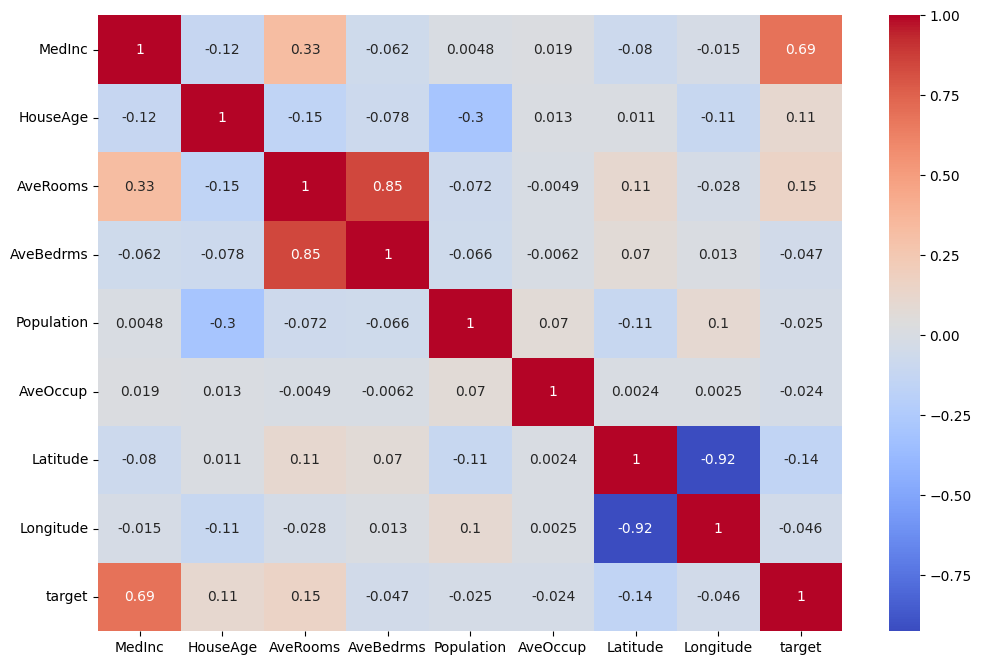

In [ ]:
plt.figure(figsize=(12,8))
california_corr = california_house_data_df.corr()
sns.heatmap(california_corr, annot=True, cmap='coolwarm')
plt.show()

La matriz de correlación muestra las siguientes correlaciones:

* AveBedrms y AveRooms con 0.85.
* Latitude y Longitude con -0.92.
* MedInc y target con 0.69.

In [ ]:
california_min_data = california_house_data_df[['AveRooms', 'AveBedrms', 'Latitude', 'Longitude', 'MedInc', 'target']]

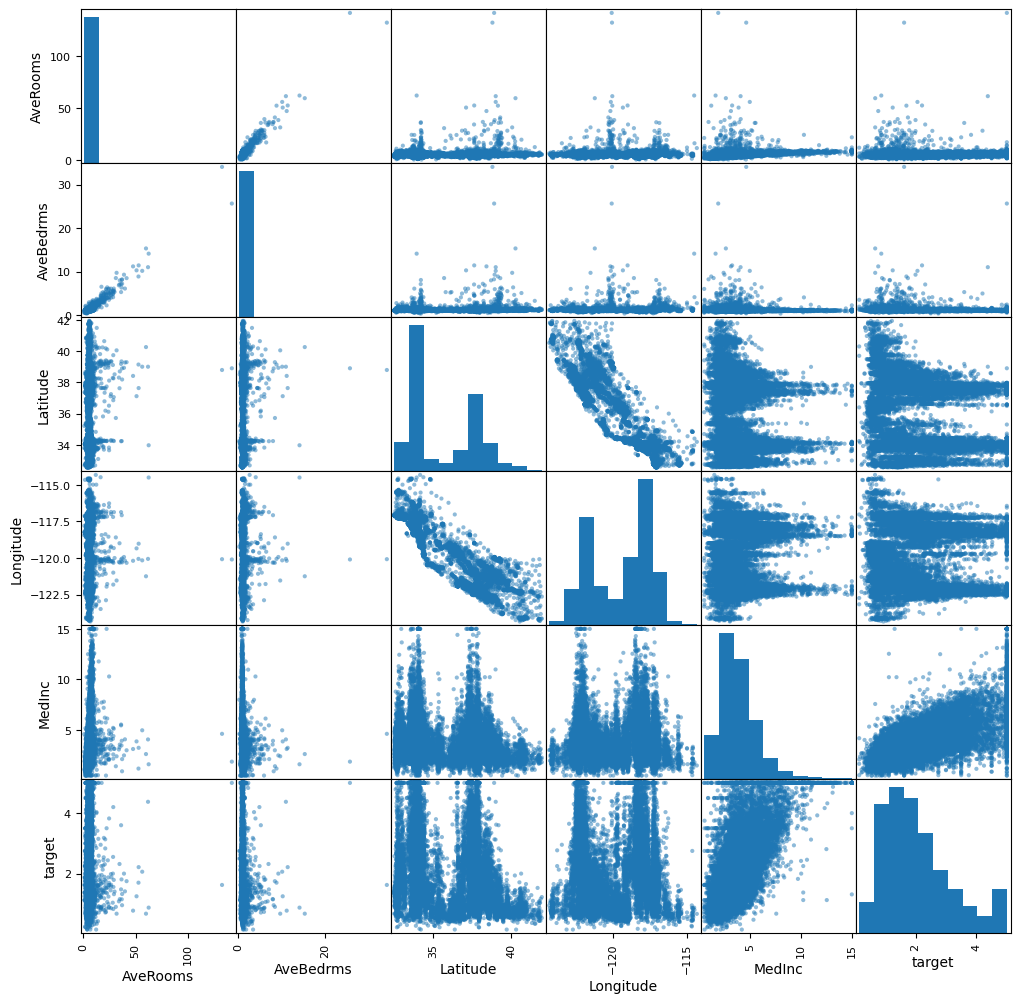

In [ ]:
scatter_matrix = pd.plotting.scatter_matrix(california_min_data, figsize=(12,12))
plt.show()

In [ ]:
X_california = california_min_data.drop('target', axis=1)
y_california = california_min_data['target']

X_california_train, X_california_test, y_california_train, y_california_test = train_test_split(X_california, y_california, test_size=TEST, random_state=SEED)

Una vez tenemos los datos escalados, vamos a preparar nuestro modelo. Usaremos un `RandomForest` y primero usaremos `RandomizedSearchCV` sobre un amplio rango para encontrar un rango pequeño y luego aplicar `GridSearchCV` sobre dicho rango para buscar los mejores hiperparámetros.

In [ ]:
param_random = {
    'n_estimators': np.arange(10, 101, 10),
    'max_depth': np.arange(2, 11),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11)
}


random_california = RandomizedSearchCV(
    RandomForestRegressor(random_state=SEED),
    param_distributions=param_random,
    n_iter=N_ITER,
    cv=CV,
    random_state=SEED
)

random_california.fit(X_california_train, y_california_train)
print('Mejores parámetros: ', random_california.best_params_)

Mejores parámetros:  {'n_estimators': np.int64(40), 'min_samples_split': np.int64(6), 'min_samples_leaf': np.int64(5), 'max_depth': np.int64(10)}


Los hiperparámetros obtenidos son:

* `max_depth`: 10
* `n_estimators`: 40
* `min_samples_split`: 6
* `min_samples_leaf`: 5

Tras esto, podemos realizar una validación con `GridSearchCV` sobre un rango más específico.

In [ ]:
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [5, 7, 10],
    'min_samples_split': [3, 6, 8],
    'min_samples_leaf': [3, 5, 7]
}

grid_california = GridSearchCV(
    RandomForestRegressor(random_state=SEED),
    param_grid=param_grid,
    cv=CV
)

grid_california.fit(X_california_train, y_california_train)
print('Mejores parámetros: ', grid_california.best_params_)

Mejores parámetros:  {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 30}


Finalmente, los hiperparámetros obtenidos en `GridSearchCV` son:

* `max_depth`: 10
* `n_estimators`: 30
* `min_samples_split`: 3
* `min_samples_leaf`: 3

En base a estos hiperparámetros, creamos nuestro modelo.

In [ ]:
california_model = RandomForestRegressor(random_state=SEED, max_depth=10, n_estimators=30, min_samples_split=3, min_samples_leaf=3)
california_model.fit(X_california_train, y_california_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=3, min_samples_split=3,
                      n_estimators=30, random_state=42)

Realizamos el mismo proceso con el modelo de `GradientBoosting`, utilizamos las mismas comprobaciones.

In [ ]:
random_cal_gradient = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=SEED),
    param_distributions=param_random,
    n_iter=N_ITER,
    cv=CV,
    random_state=SEED
)

random_cal_gradient.fit(X_california_train, y_california_train)
print('Mejores parámetros: ', random_cal_gradient.best_params_)

Mejores parámetros:  {'n_estimators': np.int64(90), 'min_samples_split': np.int64(10), 'min_samples_leaf': np.int64(2), 'max_depth': np.int64(8)}


Los hiperparámetros para el `GradientBoosting` son:

* `max_depth`: 8
* `n_estimators`: 90
* `min_samples_split`: 10
* `min_samples_leaf`: 2

Ahora repetimos los mismo con `GridSearchCV`.

In [ ]:
param_grid_g = {
    'n_estimators': [10, 30, 60, 80],
    'max_depth': [3, 5, 7],
    'min_samples_split': [3, 6, 8],
    'min_samples_leaf': [1, 2, 3]
}

grid_cal_gradient = GridSearchCV(
    GradientBoostingRegressor(random_state=SEED),
    param_grid=param_grid_g,
    cv=CV
)

grid_cal_gradient.fit(X_california_train, y_california_train)
print('Mejores parámetros: ', grid_cal_gradient.best_params_)

Mejores parámetros:  {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 80}


Los hiperparámetros obtenidos son:

* `max_depth`: 7
* `n_estimators`: 80
* `min_samples_split`: 6
* `min_samples_leaf`: 1

In [ ]:
california_gradient_model = GradientBoostingRegressor(random_state=SEED, max_depth=7, n_estimators=80, min_samples_split=6, min_samples_leaf=1)
california_gradient_model.fit(X_california_train, y_california_train)

GradientBoostingRegressor(max_depth=7, min_samples_split=6, n_estimators=80,
                          random_state=42)

Comprobamos el desempeño.

In [ ]:
y_cal_pred = california_model.predict(X_california_test)
print(f'MSE: {Metrics.mean_squared_error(y_california_test, y_cal_pred)}')
print(f'RMSE: {np.sqrt(Metrics.mean_squared_error(y_california_test, y_cal_pred))}')
print(f'R2: {Metrics.r2_score(y_california_test, y_cal_pred)}')

MSE: 0.29688783527540186
RMSE: 0.5448741462717807
R2: 0.7734387964328925


In [ ]:
y_cal_pred_gradient = california_gradient_model.predict(X_california_test)
print(f'MSE: {Metrics.mean_squared_error(y_california_test, y_cal_pred_gradient)}')
print(f'RMSE: {np.sqrt(Metrics.mean_squared_error(y_california_test, y_cal_pred_gradient))}')
print(f'R2: {Metrics.r2_score(y_california_test, y_cal_pred_gradient)}')

MSE: 0.25063858689127927
RMSE: 0.5006381796180543
R2: 0.8087325475839322


Vemos que el desempeño de nuestro modelo es de un 77%, algo bastante bueno mientras que el desempeño para el `GradientBoosting` es de 80-81%. La importancia de las características del primer modelo es la siguiente:

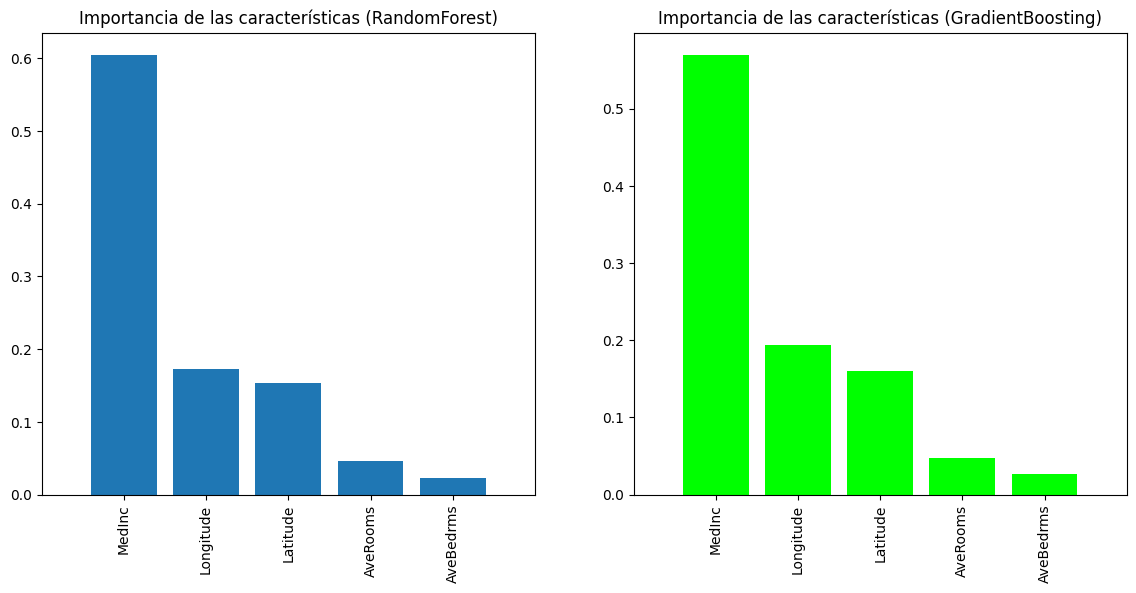

In [ ]:
importances1 = california_model.feature_importances_
indices1 = np.argsort(importances1)[::-1]
importances2 = california_gradient_model.feature_importances_
indices2 = np.argsort(importances2)[::-1]

plt.figure(figsize=(14, 6))

plt.subplot(1,2,1)
plt.title("Importancia de las características (RandomForest)")
plt.bar(range(X_california.shape[1]), importances1[indices1], align="center")
plt.xticks(range(X_california.shape[1]), X_california.columns[indices1], rotation=90)
plt.xlim([-1, X_california.shape[1]])

plt.subplot(1,2,2)
plt.title("Importancia de las características (GradientBoosting)")
plt.bar(range(X_california.shape[1]), importances2[indices2], align="center", color='lime')
plt.xticks(range(X_california.shape[1]), X_california.columns[indices2], rotation=90)
plt.xlim([-1, X_california.shape[1]])

plt.show()

Vemos que en ambos MedInc es la característica que más importancia le da debido a la alta correlación mostrada anteriormente.

---
### Ejercicio 2: Caso del agua

Listamos las columnas del dataset del agua.

In [ ]:
water_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Vemos que encontramos valores nulos en las columnas. Por lo que tendremos que realizar una estrategia para arreglar este problema. Usaremos la mediana para reemplazar los valores nulos como vimos en otros casos similares.

In [ ]:
ph_median = water_data['ph'].median()
sulfate_median = water_data['Sulfate'].median()
trihalomethanes_median = water_data['Trihalomethanes'].median()

water_data.fillna({'ph':ph_median}, inplace=True)
water_data.fillna({'Sulfate':sulfate_median}, inplace=True)
water_data.fillna({'Trihalomethanes':trihalomethanes_median}, inplace=True)

water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.036752,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,333.073546,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,333.073546,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [ ]:
water_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               3276 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          3276 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3276 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Una vez nos hemos encargado de los valores faltantes, podemos segir con el proceso de investigación. Hacemos la matriz de correlación.

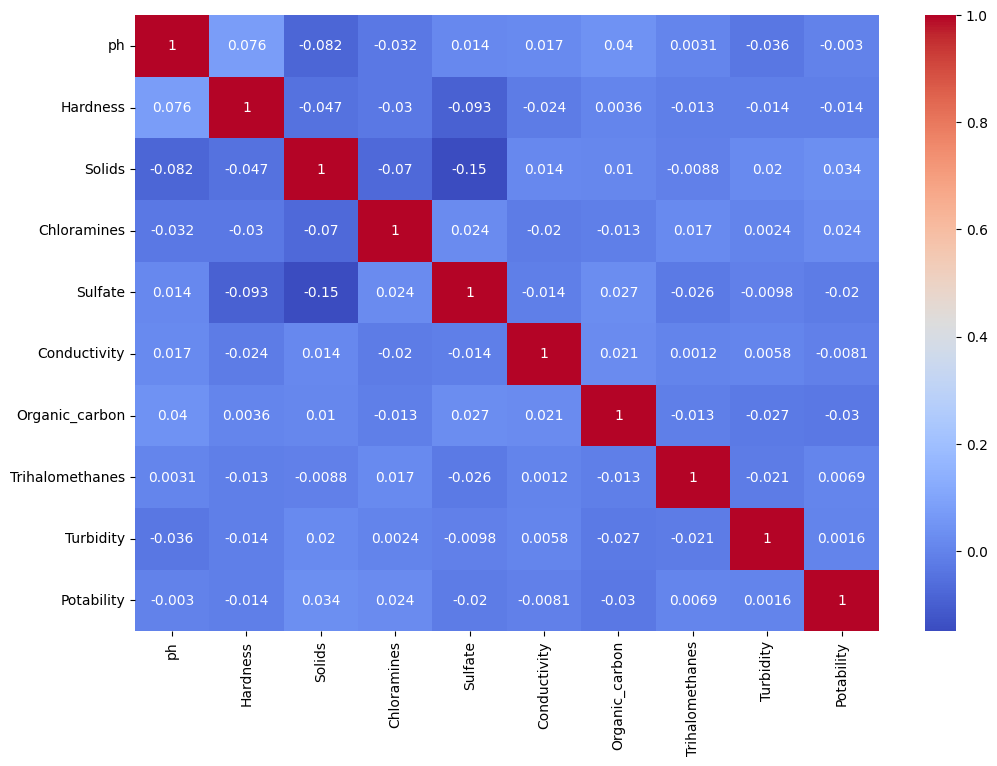

In [ ]:
plt.figure(figsize=(12,8))
water_corr = water_data.corr()
sns.heatmap(water_corr, annot=True, cmap='coolwarm')
plt.show()

Parece que apenas hay correlación entre las características. Por lo que no quitaremos ninguna.

Vamos a revisar como está nuestro objetivo que sería la potabilidad del agua.

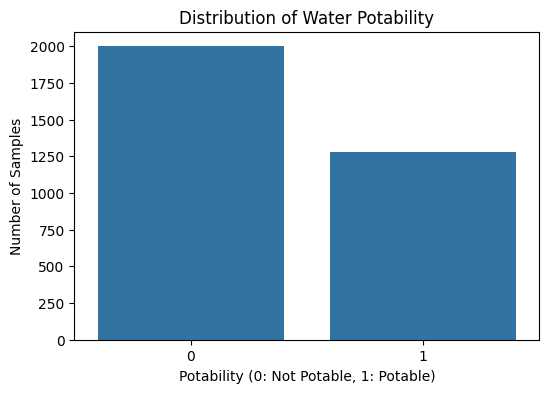

In [ ]:
potability_counts = water_data['Potability'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=potability_counts.index, y=potability_counts.values)
plt.xlabel("Potability (0: Not Potable, 1: Potable)")
plt.ylabel("Number of Samples")
plt.title("Distribution of Water Potability")
plt.show()


Vemos que el objetivo es una salida binaria de `0: Not Potable` y `1: Potable`. Vemos que hay más registros de la primera clase de la segunda, esto puede afectar al modelo por lo que tendremos que hacer submuestreo de la primera clase.

Creamos datos de entrenamiento y prueba.

In [ ]:
X_water = water_data.drop('Potability', axis=1)
y_water = water_data['Potability']

X_water_train, X_water_test, y_water_train, y_water_test = train_test_split(X_water, y_water, test_size=TEST, random_state=SEED)

Hacemos submuestreo de la primera clase. Para hacer esto hacemos los siguientes pasos:

* Separamos las clases mayoritaria (No Potable) y minoritaria (Potable)
* Hacemos submuestreo de la clase mayoritaria usando `resample`. Indicando que queremos la misma cantidad de datos que en la clase minoritaria y sin reemplazo.
* Luego unimos la clase rebajada con la minoritaria en un nuevo dataset.

Potability
0    1034
1    1034
Name: count, dtype: int64


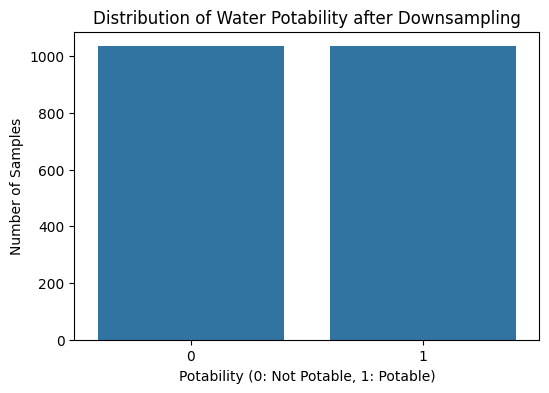

In [ ]:
water_train = pd.concat([X_water_train, y_water_train], axis=1)

# Separate majority and minority classes
df_majority = water_train[water_train['Potability']==0]
df_minority = water_train[water_train['Potability']==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),     # to match minority class
                                 random_state=SEED) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
print(df_downsampled.Potability.value_counts())

# Plot the new distribution of the target variable
potability_counts = df_downsampled['Potability'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=potability_counts.index, y=potability_counts.values)
plt.xlabel("Potability (0: Not Potable, 1: Potable)")
plt.ylabel("Number of Samples")
plt.title("Distribution of Water Potability after Downsampling")
plt.show()


Escalamos los datos de entrenamiento.

In [ ]:
X_water_train = df_downsampled.drop('Potability', axis=1)
y_water_train = df_downsampled['Potability']

Itentamos de nuevo usar `RandomizedSearchCV` sobre un amplio rango para encontrar un rango pequeño y luego aplicar `GridSearchCV` sobre dicho rango para buscar los mejores hiperparámetros.

In [ ]:
random_params = {
    'max_depth': [None, 10, 20, 30],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [5, 10, 15, 20],
    'min_samples_split': [5, 10, 15, 20]
}


random_water = RandomizedSearchCV(
    RandomForestClassifier(random_state=SEED),
    param_distributions=random_params,
    n_iter=N_ITER,
    cv=CV,
    random_state=SEED
)

random_water.fit(X_water_train, y_water_train)
print(f'Mejores hiperparámetros: {random_water.best_params_}')
print(f'Mejor puntuación de validación cruzada: {random_water.best_score_}')

Mejores hiperparámetros: {'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 20, 'criterion': 'entropy'}
Mejor puntuación de validación cruzada: 0.6242902761694213


Los resultados arrojan lo siguiente, usando estos hiperparámetros:

* `min_samples_split: 5`
* `min_samples_leaf: 5`
* `max_depth: 20`
* `criterion: 'entropy'`

Sale una precisión del 62%. Ahora usaremos `GridSearchCV` para precisar sobre estos rangos.

In [ ]:
grid_params = {
    'max_depth': [None, 5, 10, 15, 20, 25],
    'criterion': ['entropy'],
    'min_samples_leaf': [4, 6, 8, 10],
    'min_samples_split': [8, 10, 12]
}

grid_water = GridSearchCV(
    RandomForestClassifier(random_state=SEED),
    param_grid=grid_params,
    cv=CV
)

grid_water.fit(X_water_train, y_water_train)
print(f'Mejores hiperparámetros: {grid_water.best_params_}')
print(f'Mejor puntuación de validación cruzada: {grid_water.best_score_}')

Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 8}
Mejor puntuación de validación cruzada: 0.623784959820332


Los resultados de `GridSearchCV` arrojan lo siguiente, usando estos hiperparámetros:

* `min_samples_split: 8`
* `min_samples_leaf: 4`
* `max_depth: 15`
* `criterion: 'entropy'`

La precisión mejora a un 62%. Con estos resultados creamos nuestro modelo.

In [ ]:
water_model = RandomForestClassifier(min_samples_split=8, min_samples_leaf=4, max_depth=15, criterion='entropy', random_state=SEED)
water_model.fit(X_water_train, y_water_train)

RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=4,
                       min_samples_split=8, random_state=42)

In [ ]:
random_params_g = {
    'n_estimators': np.arange(10, 101, 10),
    'max_depth': np.arange(2, 11),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11)
}

random_water_gradient = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=SEED),
    param_distributions=random_params_g,
    n_iter=N_ITER,
    cv=CV,
    random_state=SEED
)

random_water_gradient.fit(X_water_train, y_water_train)
print(f'Mejores hiperparámetros: {random_water_gradient.best_params_}')
print(f'Mejor puntuación de validación cruzada: {random_water_gradient.best_score_}')

Mejores hiperparámetros: {'n_estimators': np.int64(40), 'min_samples_split': np.int64(6), 'min_samples_leaf': np.int64(5), 'max_depth': np.int64(10)}
Mejor puntuación de validación cruzada: 0.6034787287550737


Los resultados arrojan lo siguiente, usando estos hiperparámetros:

* `min_samples_split: 6`
* `min_samples_leaf: 5`
* `max_depth: 10`
* `n_estimators: 40`

Sale una precisión del 60%. Ahora usaremos `GridSearchCV` para precisar sobre estos rangos.

In [ ]:
grid_params_g = {
    'n_estimators': [5, 10, 20],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4]
}

grid_water_gradient = GridSearchCV(
    GradientBoostingClassifier(random_state=SEED),
    param_grid=grid_params_g,
    cv=CV
)

grid_water_gradient.fit(X_water_train, y_water_train)
print(f'Mejores hiperparámetros: {grid_water_gradient.best_params_}')
print(f'Mejor puntuación de validación cruzada: {grid_water_gradient.best_score_}')

Mejores hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 20}
Mejor puntuación de validación cruzada: 0.6005848568855201


Los resultados de `GridSearchCV` arrojan lo siguiente, usando estos hiperparámetros:

* `min_samples_split: 2`
* `min_samples_leaf: 4`
* `max_depth: 5`
* `n_estimators: 20`

La precisión mejora a un 60%. Con estos resultados creamos nuestro modelo de `GradientBoosting`.

In [ ]:
water_gradient_model = GradientBoostingClassifier(min_samples_split=2, min_samples_leaf=4, max_depth=5, n_estimators=20, random_state=SEED)
water_gradient_model.fit(X_water_train, y_water_train)

GradientBoostingClassifier(max_depth=5, min_samples_leaf=4, n_estimators=20,
                           random_state=42)

In [ ]:
y_water_pred = water_model.predict(X_water_test)
print(f'{Metrics.classification_report(y_water_test, y_water_pred)}')

              precision    recall  f1-score   support

           0       0.74      0.67      0.70       412
           1       0.52      0.60      0.56       244

    accuracy                           0.64       656
   macro avg       0.63      0.64      0.63       656
weighted avg       0.66      0.64      0.65       656



In [ ]:
y_water_pred_gradient = water_gradient_model.predict(X_water_test)
print(f'{Metrics.classification_report(y_water_test, y_water_pred_gradient)}')

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       412
           1       0.54      0.55      0.55       244

    accuracy                           0.66       656
   macro avg       0.64      0.64      0.64       656
weighted avg       0.66      0.66      0.66       656



Vemos que la precisión es de 64%, un poco mejor que lo que ha salido en los estimadores. El segundo modelo tiene un rendimiento de un 66%, un mucho mejor que el primero. Realizamos las matrices de confusión.

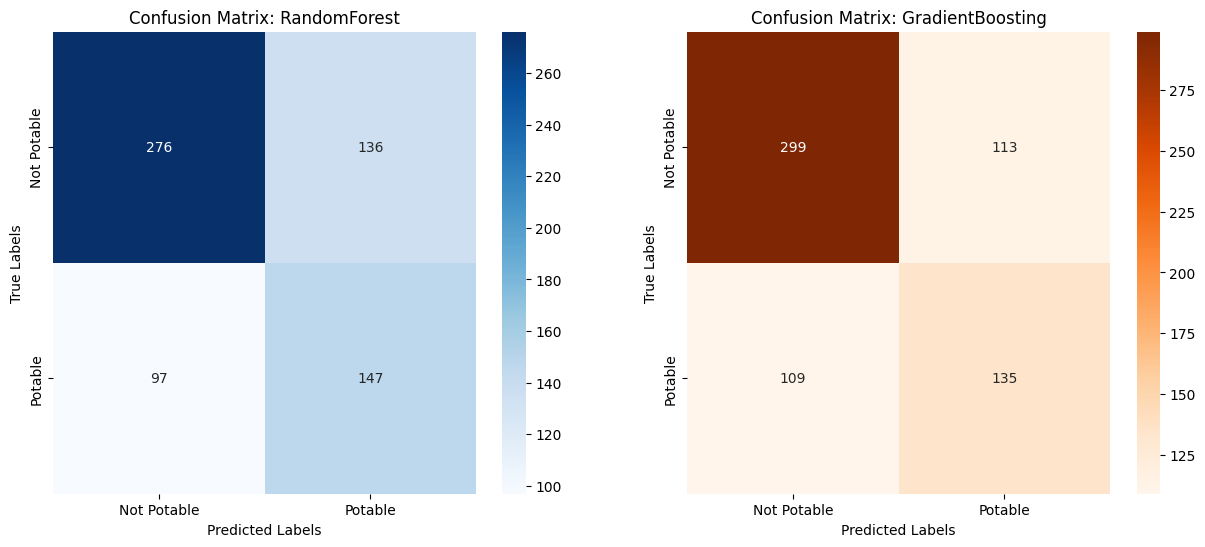

In [ ]:
water_cm = Metrics.confusion_matrix(y_water_test, y_water_pred)
water_g_cm = Metrics.confusion_matrix(y_water_test, y_water_pred_gradient)
CLASSES = ['Not Potable', 'Potable']

plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
sns.heatmap(water_cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix: RandomForest')

plt.subplot(1,2,2)
sns.heatmap(water_g_cm, annot=True, fmt='d', cmap='Oranges', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix: GradientBoosting')

plt.show()

Las matrices arrojan que aciertan bastante el agua potable pero fallan un poco más la no potable, lo cual es peligroso para la salud puesto que no se puede ingerir agua potable. La importancia de las características del primer modelo son las siguientes:

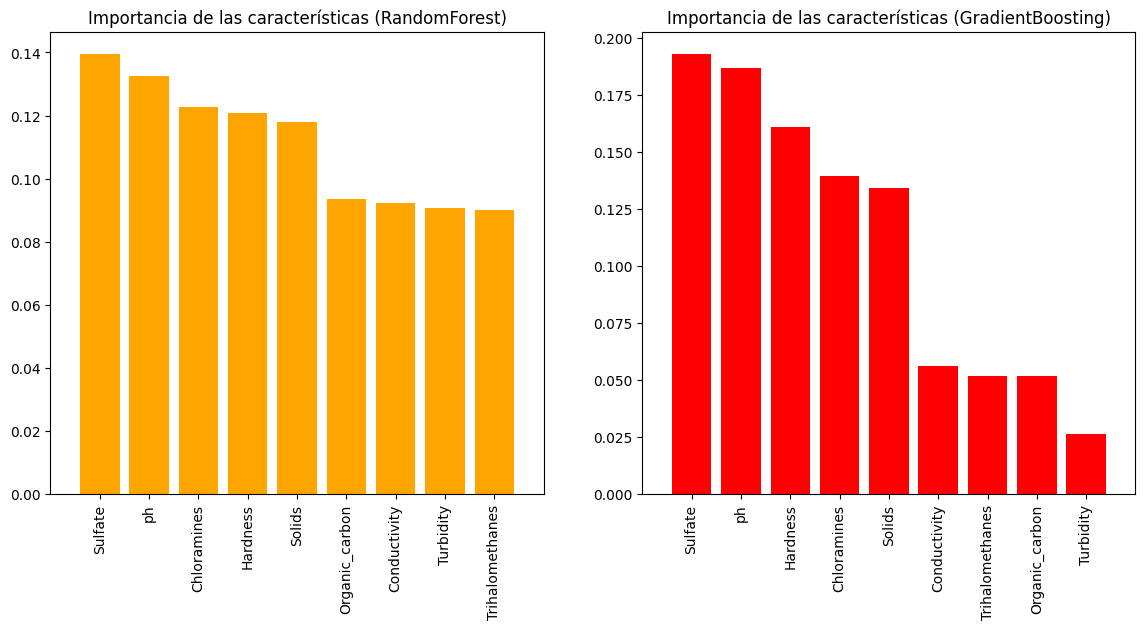

In [ ]:
importances1 = water_model.feature_importances_
indices1 = np.argsort(importances1)[::-1]
importances2 = water_gradient_model.feature_importances_
indices2 = np.argsort(importances2)[::-1]

plt.figure(figsize=(14, 6))

plt.subplot(1,2,1)
plt.title("Importancia de las características (RandomForest)")
plt.bar(range(X_water.shape[1]), importances1[indices1], align="center", color='orange')
plt.xticks(range(X_water.shape[1]), X_water.columns[indices1], rotation=90)
plt.xlim([-1, X_water.shape[1]])

plt.subplot(1,2,2)
plt.title("Importancia de las características (GradientBoosting)")
plt.bar(range(X_water.shape[1]), importances2[indices2], align="center", color='red')
plt.xticks(range(X_water.shape[1]), X_water.columns[indices2], rotation=90)
plt.xlim([-1, X_water.shape[1]])

plt.show()

Aquí se nota algunas cosas:

* Las últimas características no son tomadas tan importantes para el `GradientBoosting` que el `RandomForest`.
* La característica `Chloramines` es más importante para el `RandomForest`, mientras que `Hardless` es más importante para `GradientBoosting`.